### FairFace Dataset UDA - Domain Adversarial Neural Network (DANN)

### Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from pathlib import Path
from timm import create_model
from torchmetrics.classification import BinaryAccuracy, Accuracy

tqdm.pandas()

In [34]:
data_dir =  "./fairface_gender_classification_dataset"

# Define the folders in the training and validation directories
train_folders = ['male', 'female']
val_folders = ['male', 'female']

# Function to count the number of pictures in each folder
def count_pictures(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

# Print the number of pictures in each training folder
print("Number of pictures in each training folder:")
for folder in train_folders:
    folder_path = os.path.join(data_dir, 'Training', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

# Print the number of pictures in each validation folder
print("\nNumber of pictures in each validation folder:")
for folder in val_folders:
    folder_path = os.path.join(data_dir, 'Validation', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

Number of pictures in each training folder:
male: 45986
female: 40758

Number of pictures in each validation folder:
male: 5792
female: 5162


In [3]:

import os
import shutil
import pandas as pd
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)
print(torch.version.cuda)

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA not detected.")

random.seed(123)

# change to cpu
# device = torch.device("cpu")


cuda:0
12.1
CUDA Available: True
Device Name: NVIDIA GeForce GTX 1650 Ti
CUDA Version: 12.1


In [6]:
import requests

# Define the URL for the file
url = "https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1"

# Define the path where the file will be saved
output_path = "classification_model.pth"

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open(output_path, "wb") as file:
        file.write(response.content)  # Write the content of the response to the file
    print(f"File downloaded successfully and saved as {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")~

    # Load pre-trained ResNet model CNN-based Face-Gender-Classification PyTorch model 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer for binary classification

# Load pre-trained weights from .pth file
pretrained_weights_path = 'classification_model.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

# Send model to device
model.to(device)


File downloaded successfully and saved as classification_model.pth


### Maximum Mean Discrepancy (MMD)
1. A feature extractor shared between tasks.
2. A task classifier for the primary prediction task.
3. A domain classifier with a Gradient Reversal Layer (GRL) for adversarial training.


In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np

# MMD Loss Function
class MMDLoss(nn.Module):
    def __init__(self, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_mul = kernel_mul
        self.kernel_num = kernel_num
        self.fix_sigma = fix_sigma

    def gaussian_kernel(self, source, target):
        n_samples = source.size(0) + target.size(0)
        total = torch.cat([source, target], dim=0)
        L2_distance = torch.cdist(total, total, p=2)  # Pairwise distances
        if self.fix_sigma:
            bandwidth = self.fix_sigma
        else:
            bandwidth = torch.sum(L2_distance) / (n_samples**2 - n_samples)
        bandwidth /= self.kernel_mul ** (self.kernel_num // 2)
        bandwidth_list = [bandwidth * (self.kernel_mul**i) for i in range(self.kernel_num)]
        kernels = [torch.exp(-L2_distance**2 / bw) for bw in bandwidth_list]
        return sum(kernels)

    def forward(self, source, target):
        batch_size = source.size(0)
        kernels = self.gaussian_kernel(source, target)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY - YX)
        return loss

# Define the MMDModel
class MMDModel(nn.Module):
    def __init__(self, feature_dim=256, num_classes=2):
        super(MMDModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 53 * 53, feature_dim),  # Adjust based on input size
            nn.ReLU()
        )
        self.task_classifier = nn.Linear(feature_dim, num_classes)
        self.domain_classifier = nn.Linear(feature_dim, 1)

    def forward(self, x):
        features = self.feature_extractor(x)
        task_output = self.task_classifier(features)
        domain_output = self.domain_classifier(features)
        return task_output, domain_output

# Training function
def train_mmd(model, source_loader, target_loader, optimizer, device, epochs=10):
    model.train()
    mmd_criterion = MMDLoss().to(device)  # Use the MMDLoss class
    for epoch in range(epochs):
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        for _ in range(min(len(source_loader), len(target_loader))):
            # Source domain data
            source_data, source_labels = next(source_iter)
            source_data, source_labels = source_data.to(device), source_labels.to(device)

            # Target domain data
            target_data, _ = next(target_iter)
            target_data = target_data.to(device)

            # Forward pass
            optimizer.zero_grad()
            source_task_output, _ = model(source_data)
            target_task_output, _ = model(target_data)

            # Task loss (cross-entropy for source domain)
            task_loss = nn.CrossEntropyLoss()(source_task_output, source_labels)

            # MMD loss
            source_features = model.feature_extractor(source_data)
            target_features = model.feature_extractor(target_data)

            # Ensure the feature dimensions match
            if source_features.size(0) != target_features.size(0):
                raise RuntimeError(f"Batch size mismatch: source={source_features.size(0)}, target={target_features.size(0)}")

            mmd = mmd_criterion(source_features, target_features)  # Use MMDLoss

            # Total loss
            total_loss = task_loss + mmd
            total_loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Task Loss: {task_loss.item():.4f}, MMD Loss: {mmd.item():.4f}")
        with open('logs.txt', 'a') as f:
            f.write(f"Epoch [{epoch+1}/{epochs}], Task Loss: {task_loss.item():.4f}, MMD Loss: {mmd.item():.4f}\n")

# Evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    correct_female = 0
    total_female = 0
    correct_male = 0
    total_male = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            task_output, _ = model(data)  # Ensure your model returns both outputs properly
            _, predicted = torch.max(task_output, 1)

            # Overall accuracy
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Female accuracy (assuming class 0 is female)
            female_mask = labels == 0
            correct_female += (predicted[female_mask] == labels[female_mask]).sum().item()
            total_female += female_mask.sum().item()

            # Male accuracy (assuming class 1 is male)
            male_mask = labels == 1
            correct_male += (predicted[male_mask] == labels[male_mask]).sum().item()
            total_male += male_mask.sum().item()

    # Print results
    print(f"Test Accuracy: {correct / total:.4f}")
    if total_female > 0:
        print(f"Female Accuracy: {correct_female / total_female:.4f}")
    else:
        print("No female samples in the test set.")

    if total_male > 0:
        print(f"Male Accuracy: {correct_male / total_male:.4f}")
    else:
        print("No male samples in the test set.")
        
# Data Transforms
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Dataset Paths
aaf_dataset_path = "../Pseudo-Labeling/gender_classification_dataset_asia"
fairface_dataset_path = "../Pseudo-Labeling/fairface_gender_classification_dataset"

train_aaf = os.path.join(aaf_dataset_path, 'Training')
eval_aaf = os.path.join(aaf_dataset_path, 'Validation')
test_aaf = os.path.join(aaf_dataset_path, 'Test_balanced')

# Create ImageFolder datasets
train_aaf_dataset = ImageFolder(train_aaf, transform=transforms_train)

class FairFaceDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = os.listdir(root_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(0)  # Dummy label for domain classification~
    
# clear cuda and cache
torch.cuda.empty_cache()

    
train_fairface = os.path.join(fairface_dataset_path, 'Training/Unlabeled')

eval_aaf_dataset = ImageFolder(eval_aaf, transform=transforms_test)
test_aaf_dataset = ImageFolder(test_aaf, transform=transforms_test)
# DataLoaders
source_loader = DataLoader(train_aaf_dataset, batch_size=16, shuffle=True)
target_loader = DataLoader(
    FairFaceDataset(train_fairface, transform=transforms_train), batch_size=16, shuffle=True
)
eval_loader = DataLoader(eval_aaf_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_aaf_dataset, batch_size=16, shuffle=False)


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model Initialization
model = MMDModel(feature_dim=256, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD( model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4 )
# Switch to SGD if you notice: Overfitting to the source domain. Poor generalization to the evaluation set.

# Training
train_mmd(model, source_loader, target_loader, optimizer, device, epochs=20)

# Evaluation on AAF
evaluate(model, test_loader, device)

# save model
torch.save(model.state_dict(), 'MMD_model.pth')


RuntimeError: Batch size mismatch: source=6, target=16

In [10]:

import os
import shutil
import pandas as pd
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)
print(torch.version.cuda)

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA not detected.")

random.seed(123)


transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model = MMDModel(feature_dim=256, num_classes=2, num_domains=2)
model.load_state_dict(torch.load('MMD_model.pth', map_location=device))
# Move the model to the device
model.to(device)
model.eval()  # Set the model to evaluation mode

aaf_dataset_path = "../Pseudo-Labeling/gender_classification_dataset_asia"
test_aaf = os.path.join(aaf_dataset_path, 'Test_balanced')
test_loader = DataLoader(
    ImageFolder(test_aaf, transform=transforms_test), batch_size=32, shuffle=False
)

evaluate(model, test_loader, device)

cuda:0
12.1
CUDA Available: True
Device Name: NVIDIA GeForce GTX 1650 Ti
CUDA Version: 12.1


TypeError: MMDModel.__init__() got an unexpected keyword argument 'num_domains'

In [11]:
#PRINT INFO
import os

# Define the paths to the folders
# Define paths for the AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
# these are the paths to the training, validation, and test folders
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
validation_folder = os.path.join(aaf_dataset_path, "Validation") # this is the original validation dataset from AAF
test_folder = os.path.join(aaf_dataset_path, "Test") # this is the test dataset from AAF

# Define the paths to the female and male folders within the training folder
train_female_folder = os.path.join(train_folder, "female")
train_male_folder = os.path.join(train_folder, "male")

# Define the paths to the female and male folders within the validation folder
validation_female_folder = os.path.join(validation_folder, "female")
validation_male_folder = os.path.join(validation_folder, "male")

# Define the paths to the female and male folders within the test folder
test_female_folder = os.path.join(test_folder, "female")
test_male_folder = os.path.join(test_folder, "male")

# Count the number of samples in each folder
num_train_female_samples = len(os.listdir(train_female_folder))
num_train_male_samples = len(os.listdir(train_male_folder))
num_validation_female_samples = len(os.listdir(validation_female_folder))
num_validation_male_samples = len(os.listdir(validation_male_folder))
num_test_female_samples = len(os.listdir(test_female_folder))
num_test_male_samples = len(os.listdir(test_male_folder))

# Calculate the totals
total_train_samples = num_train_female_samples + num_train_male_samples
total_validation_samples = num_validation_female_samples + num_validation_male_samples
total_test_samples = num_test_female_samples + num_test_male_samples

# Print the counts
print("Number of samples in Training - Female:", num_train_female_samples)
print("Number of samples in Training - Male:", num_train_male_samples)
print("Total samples in Training:", total_train_samples)
print("Number of samples in Validation - Female:", num_validation_female_samples)
print("Number of samples in Validation - Male:", num_validation_male_samples)
print("Total samples in Validation:", total_validation_samples)
print("Number of samples in Test - Female:", num_test_female_samples)
print("Number of samples in Test - Male:", num_test_male_samples)
print("Total samples in Test:", total_test_samples)


Number of samples in Training - Female: 12927
Number of samples in Training - Male: 28244
Total samples in Training: 41171
Number of samples in Validation - Female: 1584
Number of samples in Validation - Male: 1262
Total samples in Validation: 2846
Number of samples in Test - Female: 1583
Number of samples in Test - Male: 1262
Total samples in Test: 2845


In [12]:
# Calculate the number of male samples to remove to balance the dataset
num_samples_to_remove = max(0, num_train_male_samples - num_train_female_samples)

# Remove the excess male samples
if num_samples_to_remove > 0:
    male_files = os.listdir(train_male_folder)
    # Remove the first num_samples_to_remove male samples
    for i in range(num_samples_to_remove):
        file_to_remove = os.path.join(train_male_folder, male_files[i])
        os.remove(file_to_remove)

    # Update the count of male samples
    num_train_male_samples -= num_samples_to_remove

    # Recalculate the total number of samples in the training dataset
    total_train_samples = num_train_female_samples + num_train_male_samples

# Print the updated counts
print("Number of samples in Training - Female:", num_train_female_samples)
print("Number of samples in Training - Male:", num_train_male_samples)
print("Total samples in Training:", total_train_samples)


Number of samples in Training - Female: 12927
Number of samples in Training - Male: 12927
Total samples in Training: 25854


In [13]:
# create dataloaders
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the paths to the folders AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia" # this is the All-Asian-Face Dataset 
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the training data from pseudo-labelling of FairFace
validation_folder = os.path.join(aaf_dataset_path, "Validation")
test_folder = os.path.join(aaf_dataset_path, "Test")


# Create ImageFolder datasets
train_dataset = ImageFolder(train_folder, transform=transforms_train)
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
test_dataset = ImageFolder(test_folder, transform=transforms_test)
\
# Define batch size
batch_size = 16

# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
import numpy as np

def show_samples(dataloader, dataset_name):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Samples from {dataset_name} Dataset")
    for ax in axes.flatten():
        ax.axis('off')

    for i, (inputs, labels) in enumerate(dataloader):
        if i == 6:
            break
        ax = axes[i // 3, i % 3]
        # Show the image using imshow function
        imshow(inputs[0], title=f"Label: {labels[0]}")
        ax.axis('on')

# Show samples from training dataset
show_samples(train_dataloader, "Training")

# Show samples from validation dataset
show_samples(val_dataloader, "Validation")

# Show samples from test dataset
show_samples(test_dataloader, "Test")



Class names: ['female', 'male']
[Prediction Result Examples]


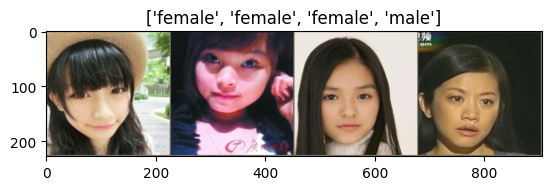

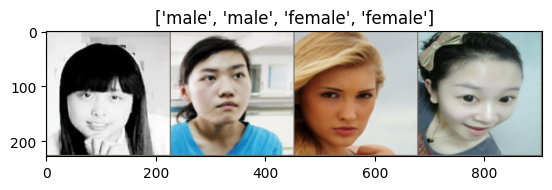

[Test] Loss: 1.1634 Acc: 75.7821% Time: 22.2755s
[Test] Male Accuracy: 97.3851%
[Test] Female Accuracy: 58.5597%


In [17]:

# Validation Phase
# import imshow
import numpy as np
import matplotlib.pyplot as plt
# Define a function to display images
def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

class_names = test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                        time.time() - start_time))

    print('[Test] Male Accuracy: {:.4f}%'.format(male_acc))
    print('[Test] Female Accuracy: {:.4f}%'.format(female_acc))

Class names: ['female', 'male']
[Prediction Result Examples]


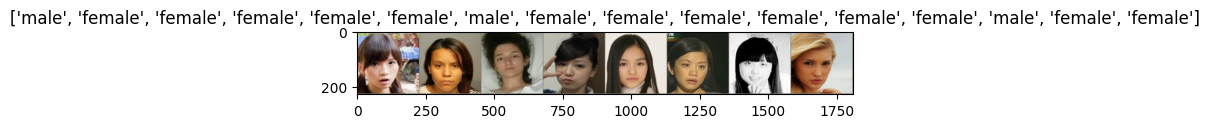

[Validation] Loss: 0.7668 Acc: 74.8067% Time: 77.5598s
[Validation] Male Accuracy: 96.9097%
[Validation] Female Accuracy: 57.2331%


In [22]:
# Test Phase
class_names = test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            pred_labels = [class_names[x] for x in preds]
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=pred_labels)

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                        time.time() - start_time))

    print('[Validation] Male Accuracy: {:.4f}%'.format(male_acc))
    print('[Validation] Female Accuracy: {:.4f}%'.format(female_acc))

Class names: ['female', 'male']
[Prediction Result Examples]


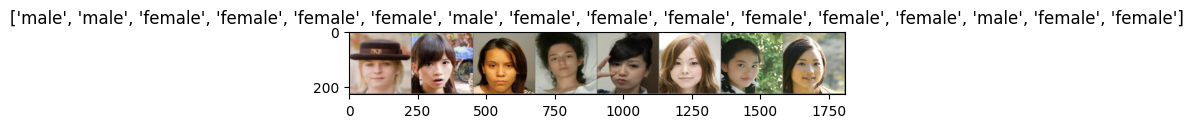

[Validation] Loss: 1.2003 Acc: 75.2284% Time: 20.6876s
[Validation] Male Accuracy: 97.7021%
[Validation] Female Accuracy: 57.3232%


In [18]:
# Validation Phase, using validation dataset
class_names = val_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            pred_labels = [class_names[x] for x in preds]
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=pred_labels)

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                        time.time() - start_time))

    print('[Validation] Male Accuracy: {:.4f}%'.format(male_acc))
    print('[Validation] Female Accuracy: {:.4f}%'.format(female_acc))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms



# Define transforms for training and validation data
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_unlabeled = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
